# `torchdyn`Quickstart

**torchdyn is the toolkit for continuous models in PyTorch. Play with state-of-the-art architectures or use its class and function primitives to create your own.**

Central to the `torchdyn` approach are continuous and implicit neural networks, where *depth* is taken to its infinite limit.

By providing a centralized, easy-to-access collection of model templates, tutorial and application notebooks, we hope to speed-up research in this area and ultimately contribute to turning neural differential equations into an effective tool for control, system identification and common machine learning tasks.


In [1]:
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *

%load_ext autoreload
%autoreload 2

In [2]:
# quick run for automated notebook validation
dry_run = False

## Generate data from a static toy dataset 

We’ll be generating data from toy datasets. In torchdyn, we provide a wide range of datasets often use to benchmark and understand Neural ODEs. Here we will use the classic moons dataset and train a Neural ODE for binary classification

In [4]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='moons')        

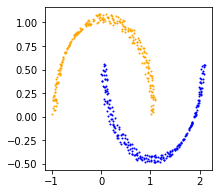

In [5]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

Generated data can be easily loaded in the dataloader with standard `PyTorch` calls

In [6]:
import torch
import torch.utils.data as data
device = torch.device("cpu") # all of this works in GPU as well :)

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

We utilize [Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) to handle training loops, logging and general bookkeeping. This allows `torchdyn` and Neural Differential Equations to have access to modern best practices for training and experiment reproducibility. 

In particular, we combine modular `torchdyn` models with `LightningModules` via a `Learner` class:

In [7]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Define a  Neural ODE

Analogously to most forward neural models we want to realize a map 

$$
        x \mapsto \hat y
$$

where  $\hat y$ becomes the best approximation of a true output $y$ given an input $x$.
In torchdyn you can define very simple Neural ODE models of the form 

$$ \left\{
    \begin{aligned}
        \dot{z}(t) &= f(z(t), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad t\in[0,1]
$$

by just specifying a neural network $f$ and giving some simple settings.

**Note:** This Neural ODE model is of *depth-invariant* type as neither $f$ explicitly depend on $s$ nor the parameters $\theta$ are depth-varying. Together with their *depth-variant* counterpart with $s$ concatenated in the vector field was first proposed and implemented by [[Chen T. Q. et al, 2018]](https://arxiv.org/abs/1806.07366)

### Define the vector field (DEFunc) 

The first step is to define any PyTorch `torch.nn.Module`. This takes the role of the Neural ODE vector field $f(h,\theta)$ 

In [8]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)                       
    )
t_span = torch.linspace(0, 1, 5)

In this case we chose $f$ to be a simple MLP with one hidden layer and $\tanh$ activation

### Define the NeuralDE

The final step to define a Neural ODE is to instantiate the torchdyn's class `NeuralDE` passing some customization arguments and `f` itself.

In this case we specify:
* we compute backward gradients with the `'adjoint'` method.
* we will use the `'dopri5'` (Dormand-Prince) ODE solver from `torchdyn`, with no additional options;

In [9]:
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


## Train the Model

With the same forward method of `NeuralDE` objects you can quickly evaluate the entire trajectory of each data point in `X_train` on an interval `t_span`

In [10]:
t_span = torch.linspace(0,1,100)
t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()

The numerical method used to solve a `NeuralODE` have great effect on its speed. Try retraining with the following

In [11]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)                       
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

learn = Learner(t_span, model)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=200, max_epochs=300)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 82    
------------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

### Plot the Training Results

We can first plot the trajectories of the data points in the depth domain $s$

Text(0.5, 1.0, 'Dimension 1')

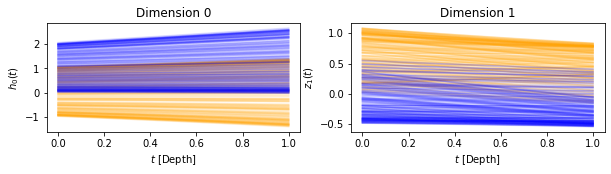

In [12]:
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(500):
    ax0.plot(t_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(t_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")

Then the trajectory in the *state-space*

As you can see, the Neural ODE steers the data-points into regions of null loss with a continuous flow in the depth domain. Finally, we can also plot the learned vector field $f$

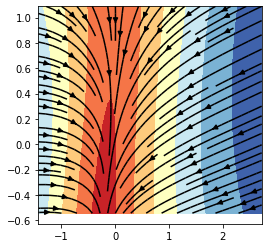

In [13]:
# evaluate vector field
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
f = model.vf(0,z.to(device)).cpu().detach()
fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')

**Sweet! You trained your first Neural ODEs! Now you can proceed and learn about more advanced models with the next tutorials**